[View in Colaboratory](https://colab.research.google.com/github/gmlander/Springboard/blob/master/Portfolio/Computer_Vision_With_Boosted_Augmentation/Xception_training.ipynb)

# iMaterialist


>[iMaterialist](#scrollTo=KoKsvGtPgQ8G)

>>[Setup and Imports](#scrollTo=-MCEMjFK1Hp2)

>>>[Connect GoogleDrive Store](#scrollTo=j8bj-md7cBSh)

>>>[Imports](#scrollTo=Npq_E4hFgtRt)

>>>[Create folders structure](#scrollTo=y0BHYxQ8UxEL)

>>>[Utility Functions](#scrollTo=OUnD_RZsjPPb)

>>>[Generator Class](#scrollTo=ZrGqsYAy-bfl)

>>[Initial Testing](#scrollTo=-kqU7ZW80E9V)

>>>[Load Speed Tests](#scrollTo=s6ws3ZHEzMvG)

>>>>[h5 v npy test](#scrollTo=BuJC8I0Fs4bX)

>>>>[Chunk Tests](#scrollTo=q4Yk7oh-Qujf)

>>>>[Memmap Tests](#scrollTo=uS9wdftiw-MS)

>>>>[Big HDF5 vs Small HDF5](#scrollTo=hlhdmneowDMN)

>>[Compute Additional Data for Training](#scrollTo=ysHmJXm41XXj)

>>>>[Get Training Image $\sigma$](#scrollTo=FfxWQvYZY1xp)

>>>>[Compute Label Weights](#scrollTo=wqB4sFAzvFvp)

>>>[Augmentation Tests](#scrollTo=7wJPEj_9RAuF)

>>[Xception Model](#scrollTo=PB2WUaUVmGFV)

>>>[Initial Load](#scrollTo=0GtV7NGsEZM8)

>>>[Load Latest Model](#scrollTo=WM5cXZvCFfjv)

>>>[Train Model](#scrollTo=gF9K_LdUPpF5)

>>>>[Initial Params, Callbacks, and Other Data](#scrollTo=6Msod-3al97Z)

>>>>[Create Generators](#scrollTo=mdXSz_SYP3ae)

>>>>[Fit Model](#scrollTo=89C-du0euer5)



## Setup and Imports

### Connect GoogleDrive Store

In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

### Imports

In [0]:
from __future__ import print_function
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils, Sequence
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping
from keras.optimizers import Adam
from keras.models import Model, load_model
from keras.applications import Xception, imagenet_utils
from keras.layers import Dense, GlobalAveragePooling2D, Dropout 

from random import randrange
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import h5py
import os

import time
from sys import getsizeof

Using TensorFlow backend.


### Create folders structure

In [0]:
os.chdir('/content/drive')
os.makedirs('nasnet', exist_ok=True)
os.chdir('nasnet')
os.makedirs('weights', exist_ok=True)

### Utility Functions

In [0]:
def elapsed (start):
    """
    Returns elapsed time in hh:mm:ss format from start time in unix format
    """
    elapsed = time.time()-start
    hours, rem = divmod(elapsed, 3600)
    minutes, seconds = divmod(rem, 60)
    return("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))
  
def load_dataset(file, first = None, last = None, key = None, preprocess = True, raw_labels = False):
    if not key:
        start = file.rindex('/') + 1
        end = file.rindex('_', start )
        key = file[start:end]

    try:
        classes = nb_classes
    except:
        classes = 128
   
    
    with h5py.File(file, 'r') as hf:
        images = hf[key]['images'][first:last]
        labels= hf[key]['labels'][first:last]

    if preprocess:
        images = images.astype('float32', copy=False)
        images /= 127.5
        images -= 1.
    
    if raw_labels:
        return (images, labels)
  
    labels = np.reshape(labels, (len(labels), 1))
    labels = labels.astype(np.uint8, copy=False)
    labels = np_utils.to_categorical(labels, classes)

    return (images, labels)

# Refactored with optional shuffle argument, since filelist ends up being shuffled
# by Sequence generator automatically. Defaulted to True for compatability with
# previous calls.
def load_filelist(path, max = None, prefix = 'train_', shuffle = True):
    filelist = []
    for file in os.listdir(path)[:max]:
          if file.startswith(prefix):
                filelist.append(os.path.join(path,file))
    if shuffle:
        np.random.shuffle(filelist)
    return filelist

def combine_hdf5(train_files, save_name, test_files = None, store_mean = False, verbose = False):
    '''
    Takes an array of training file names (and optionally test file names), and
    saves them in a consolidated hdf5 file. Can also store the mean pixel values
    of the training files if they are needed later for image processing/scaling.
    '''
    train_shape = (1000*len(train_files), 224, 224, 3)

    # create file and structure based on inputs
    hdf5_file = h5py.File(save_name, mode='w')
    hdf5_file.create_group('train')
    hdf5_file['train'].create_dataset("images", train_shape, np.uint8)
    hdf5_file['train'].create_dataset("labels", (train_shape[0],), np.uint8)


    if store_mean:
        hdf5_file['train'].create_dataset("mean", train_shape[1:], np.float32)
        mean = np.zeros(train_shape[1:], np.float32)

    if test_files:
        hdf5_file.create_group('test')
        test_shape = (1000*len(test_files), 224, 224, 3)
        hdf5_file['test'].create_dataset("images", test_shape, np.uint8)
        hdf5_file['test'].create_dataset("labels", (test_shape[0],), np.uint8)


  # open and write each train file
    for i, file in enumerate(train_files):
          if verbose:
            print('Reading file {} ---'.format(i+1),file)

        images, labels = load_dataset(file, preprocess = False, raw_labels = True)

        # save the images and labels
        hdf5_file['train']["images"][i*1000:1000*(i+1), ...] = images
        hdf5_file['train']["labels"][i*1000:1000*(i+1),] = labels

        # calculate mean portion of batch and add to mean var
        if store_mean:
            mean += np.sum((images/float(train_shape[0])), axis=0, keepdims=False)

        if test_files:
        # open and write each test file
        for i, file in enumerate(test_files):
            if verbose:
                print('Reading file {} ---'.format(i+1+len(train_files)),file)

        images, labels = load_dataset(file, preprocess = False, raw_labels = True)

        # save the images and labels
        hdf5_file['test']["images"][i*1000:1000*(i+1), ...] = images
        hdf5_file['test']["labels"][i*1000:1000*(i+1),] = labels


    # save the mean
    if store_mean:
        hdf5_file["train"]['mean'][...] = mean

    # close the file. pray.
    hdf5_file.close()
  
    if verbose:
        print('Complete.',save_name,'has been built!')

# Adapted from https://github.com/titu1994/Keras-NASNet/blob/master/cutout.py
# Default cuts and multipliers added too much correction for this data. 
# Original version assumed a batch of images and applied same cuts to all.
# This version works image by image.
def cutout(img, MAX_CUTS = 5, MAX_LENGTH_MULTIPLIER = 8):
    '''
    Adds a random number (up to MAX_CUTS) of randomly sized black patches to the
    image. Each patch is a square with edge length =
                                4 x a random number [1,MAX_LENGTH_MULTIPLIER)
    Helps to regularize model, preventing it from looking at the same features
    every time it sees an image.
    
    Note, can customize the params when using this as the function for
    preprocessing_function argument of ImageDataGenerator by using partial.
    
    EX:
    from functools import partial
    new_cutout = partial(cutout, MAX_CUTS = 3, MAX_LENGTH_MULTIPLIER = 15)
    ImageDataGenerator(...,preprocessing_function = new_cutout)
    '''
    
    height = 224
    width = 224
    mask = np.ones((height, width,3), np.float32)
    nb_cuts = np.random.randint(0, MAX_CUTS + 1)

    for i in range(nb_cuts):
        y = np.random.randint(height)
        x = np.random.randint(width)
        length = 4 * np.random.randint(1, MAX_LENGTH_MULTIPLIER + 1)

        y1 = np.clip(y - length // 2, 0, height)
        y2 = np.clip(y + length // 2, 0, height)
        x1 = np.clip(x - length // 2, 0, width)
        x2 = np.clip(x + length // 2, 0, width)

        mask[y1:y2, x1:x2] = 0.
    img = img * mask
    return img

### Generator Class

Build a class to handle multiprocessed/pooled batch loading, normalizing, and (optionally) augmentation during model training.

In [0]:
class FullDataGenerator(Sequence):
    'Generates data for Keras -- Assumes one large hdf5 file for all data.'
    def __init__(self, file, train_mean, train_std, key = 'train', batch_size=10,
                 file_size = 189000, augment_generator = None, shuffle=None):
        'Initialization'
        assert file_size % batch_size == 0
        self.file = file
        self.key = key
        self.batch_size = batch_size
        self.file_size = file_size
        self.train_mean = train_mean
        self.train_std = train_std
        self.shuffle = shuffle
        self.batches = file_size // batch_size
        self.augment_generator = augment_generator
        
        # handle data augmentation from a passed generator
        if augment_generator:
            self.augmentation = True
            if augment_generator.featurewise_center or \
            augment_generator.featurewise_std_normalization or \
            augment_generator.zca_whitening:
                self.batch_fit = True
        else:
            self.batch_fit = False
        else:
            self.augmentation = False
          
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch.'
        return self.batches
          

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes based on shuffle style
        if self.shuffle == 'full':
            batch_ix = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        else:
            batch_ix = self.indexes[index]

        # Generate data
        X, y = self.__data_generation(batch_ix)
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch - size based on shuffle type'
        if self.shuffle != 'full':
            self.indexes = np.arange(self.batches)
            if self.shuffle == 'semi':
                np.random.shuffle(self.indexes)
        else:
            self.indexes = np.arange(self.file_size)
            np.random.shuffle(self.indexes)
          

    def __data_generation(self, batch_ix):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        with h5py.File(self.file, 'r') as hf:
            if self.shuffle == 'full':
                X = hf[self.key]['images'][batch_ix]
                y = hf[self.key]['labels'][batch_ix]
            else:
                start = batch_ix*self.batch_size
                stop = (batch_ix + 1)*self.batch_size
                X = hf[self.key]['images'][start:stop]
                y = hf[self.key]['labels'][start:stop]

        # standard preprocess steps
        X = X.astype('float32', copy=False)
        y = np.reshape(y, (len(y), 1))
        y -= 1
        y = np_utils.to_categorical(y, 128)

        # augmentation
        if self.augmentation:
            if self.batch_fit: 
                self.augment_generator.fit(X)
            for i in range(X.shape[0]):
                X[i] = self.augment_generator.random_transform(X[i])
        X -= self.train_mean
        X /= self.train_std

        return X, y

## Initial Testing

---

Since there are 189000 images in this training set, stored as h5's of 1k labeled images each, as well as 6k images in the test set (same structure), loading and shuffling images from disk to ram to gpu ram and back and forth over and over again will significantly slow down the model.  The intent of these load speed tests will be to find the most economical data format.

### Load Speed Tests

#### h5 v npy test



- **full image data**

In [0]:
arr, _ = load_dataset('../iMaterialist/test_1.h5')
np.savez("arr.npz", **{"arr": arr})
np.save("arr.npy", arr)
with h5py.File("arr.h5", "w") as hf:
    hf.create_dataset("arr", data=arr)

ltime = []
for i in range(20):
    start = time.time()
    arr = np.load("arr.npy")[:, :]
    ltime.append(time.time() - start)

print("npy -- time: {:0.5f}\tsize: {:0.5f}".format(np.mean(ltime), getsizeof(arr)/2**20))

ltime = []
for i in range(20):
    start = time.time()
    arr = np.load("arr.npz")["arr"][:, :]
    ltime.append(time.time() - start)

print("npz -- time: {:0.5f}\tsize: {:0.5f}".format(np.mean(ltime), getsizeof(arr)/2**20))


ltime = []
for i in range(20):
    start = time.time()
    with h5py.File("arr.h5", "r") as hf:
        arr = hf["arr"][:, :]
        ltime.append(time.time() - start)

print("hdf5 -- time: {:0.5f}\tsize: {:0.5f}".format(np.mean(ltime), getsizeof(arr)/2**20))

npy -- time: 7.30505	size: 0.00014
npz -- time: 7.18675	size: 0.00014
hdf5 -- time: 6.85024	size: 574.21889


- **10 images**


In [0]:
arr, _ = load_dataset('../iMaterialist/test_1.h5', first = 0, last = 10)
np.savez("arr2.npz", **{"arr": arr})
np.save("arr2.npy", arr)
with h5py.File("arr2.h5", "w") as hf:
    hf.create_dataset("arr", data=arr)

ltime = []
for i in range(20):
    start = time.time()
    arr = np.load("arr2.npy")[:, :]
    ltime.append(time.time() - start)

print("npy -- time: {:0.5f}".format(np.mean(ltime)))

ltime = []
for i in range(20):
    start = time.time()
    arr = np.load("arr2.npz")["arr"][:, :]
    ltime.append(time.time() - start)

print("npz -- time: {:0.5f}".format(np.mean(ltime)))


ltime = []
for i in range(20):
    start = time.time()
    with h5py.File("arr2.h5", "r") as hf:
        arr = hf["arr"][:, :]
        ltime.append(time.time() - start)

print("hdf5 -- time: {:0.5f}\tsize: {:0.5f}".format(np.mean(ltime), getsizeof(arr)/2**20))

npy -- time: 0.07817
npz -- time: 0.07856
hdf5 -- time: 0.07182	size: 5.74232


#### Chunk Tests

In [0]:
arr, _ = load_dataset('../iMaterialist/test_1.h5', preprocess = False)
with h5py.File("creamy.h5", "w") as hf:
    hf.create_dataset("arr", data=arr)
with h5py.File("chunky.h5", "w") as hf:
    hf.create_dataset("arr", data=arr, chunks = (1,224,224,3))
with h5py.File("superchunk.h5", "w") as hf:
    hf.create_dataset("arr", data=arr, chunks = (25,224,224,3))

- **10 images at a time**

In [0]:
ltime = {'creamy':[],'chunky':[],'superchunk':[]}
for i in range(20):
    ix = np.random.randint(0,99)
    for file in ['creamy','chunky','superchunk']:
        start = time.time()
        with h5py.File("{}.h5".format(file), "r") as hf:
            arr = hf["arr"][ix*10:(ix+1)*10]
        ltime[file].append(time.time() - start)
        
for file in ['creamy','chunky','superchunk']:
    print("{} -- time: {:0.5f}".format(file, np.mean(ltime[file])))

creamy -- time: 0.02341
chunky -- time: 0.02722
superchunk -- time: 0.02614


- **25 images at a time**

In [0]:
ltime = {'creamy':[],'chunky':[],'superchunk':[]}
for i in range(20):
    ix = np.random.randint(0,39)
    for file in ['creamy','chunky','superchunk']:
        start = time.time()
        with h5py.File("{}.h5".format(file), "r") as hf:
            arr = hf["arr"][ix*25:(ix+1)*25]
        ltime[file].append(time.time() - start)
for file in ['creamy','chunky','superchunk']:
    print("{} -- time: {:0.5f}".format(file, np.mean(ltime[file])))

creamy -- time: 0.07332
chunky -- time: 0.05197
superchunk -- time: 0.04969


#### Memmap Tests

In [0]:
ltime = []
for i in range(20):
    start = time.time()
    arr = np.load("arr.npy", mmap_mode='r')[(i+5)*10:(i+6)*10]
    ltime.append(time.time() - start)

print("npy -- time: {:0.5f}".format(np.mean(ltime)))

ltime = []
for i in range(20):
    start = time.time()
    with h5py.File("arr.h5", "r") as hf:
        arr = hf["arr"][(i+5)*10:(i+6)*10]
        ltime.append(time.time() - start)

print("hdf5 -- time: {:0.5f}\tsize: {:0.5f}".format(np.mean(ltime), getsizeof(arr)/2**20))

npy -- time: 0.31905
hdf5 -- time: 0.38626	size: 5.74232


**NOTE**:

Something odd is going on with caching in the Colab environment, where recently opened files open much faster on subsequent calls. While this is of course a great feature for people trying to use a cloud storage environment, it is horribly inconvient for someone trying to test load speeds in one! Next up ... the big one!

#### Big HDF5 vs Small HDF5

Testing on an hdf5 file of 90k images as this will be large enough to not be fully loaded into memory ($\geq12\ GB$). This way the performance between a large file and single files cannot be hidden by caching.

**WARNING:** Do not run the cells to build this merged hdf5 unless you know you have the space and time for it.

In [0]:
!free -m

              total        used        free      shared  buff/cache   available
Mem:          13029        1964         161         247       10902       10569
Swap:             0           0           0


In [0]:
12/(144/2**10)

85.33333333333333

In [0]:
build_list = load_filelist('../iMaterialist', shuffle = False)[:90]
combine_hdf5(build_list, 'jumbo.h5', verbose = True)

Reading file --- ../iMaterialist/train_167.h5
Reading file --- ../iMaterialist/train_2.h5
Reading file --- ../iMaterialist/train_8.h5
Reading file --- ../iMaterialist/train_93.h5
Reading file --- ../iMaterialist/train_101.h5
Reading file --- ../iMaterialist/train_175.h5
Reading file --- ../iMaterialist/train_7.h5
Reading file --- ../iMaterialist/train_59.h5
Reading file --- ../iMaterialist/train_24.h5
Reading file --- ../iMaterialist/train_130.h5
Reading file --- ../iMaterialist/train_82.h5
Reading file --- ../iMaterialist/train_183.h5
Reading file --- ../iMaterialist/train_69.h5
Reading file --- ../iMaterialist/train_142.h5
Reading file --- ../iMaterialist/train_80.h5
Reading file --- ../iMaterialist/train_45.h5
Reading file --- ../iMaterialist/train_53.h5
Reading file --- ../iMaterialist/train_148.h5
Reading file --- ../iMaterialist/train_152.h5
Reading file --- ../iMaterialist/train_100.h5
Reading file --- ../iMaterialist/train_151.h5
Reading file --- ../iMaterialist/train_99.h5
Rea

Reading file --- ../iMaterialist/train_86.h5
Reading file --- ../iMaterialist/train_111.h5
Reading file --- ../iMaterialist/train_116.h5
Reading file --- ../iMaterialist/train_132.h5
Reading file --- ../iMaterialist/train_189.h5
Reading file --- ../iMaterialist/train_127.h5
Reading file --- ../iMaterialist/train_107.h5
Reading file --- ../iMaterialist/train_98.h5
Reading file --- ../iMaterialist/train_126.h5
Reading file --- ../iMaterialist/train_11.h5
Reading file --- ../iMaterialist/train_158.h5
Reading file --- ../iMaterialist/train_16.h5
Reading file --- ../iMaterialist/train_76.h5
Reading file --- ../iMaterialist/train_94.h5
Reading file --- ../iMaterialist/train_187.h5
Reading file --- ../iMaterialist/train_61.h5
Reading file --- ../iMaterialist/train_125.h5
Reading file --- ../iMaterialist/train_12.h5
Reading file --- ../iMaterialist/train_121.h5
Reading file --- ../iMaterialist/train_27.h5
Reading file --- ../iMaterialist/train_58.h5
Reading file --- ../iMaterialist/train_124.h

**Bonus Round -- Write last files**  
Colab wanted to up the difficulty for me on this and decided to disconnect during the 3rd to last file. Joy!

In [0]:
last_files = build_list[87:]


# create file and structure based on inputs
hdf5_file = h5py.File('jumbo.h5', mode='r+')

# open and write each train file
for i, file in enumerate(last_files):
    print('Reading file ---',file)

    images, labels = load_dataset(file, preprocess = False, raw_labels = True)

    # save the images and labels
    hdf5_file['train']["images"][(i+87)*1000:1000*(i+88), ...] = images
    hdf5_file['train']["labels"][(i+87)*1000:1000*(i+88),] = labels

hdf5_file.close()

Reading file --- ../iMaterialist/train_124.h5
Reading file --- ../iMaterialist/train_51.h5
Reading file --- ../iMaterialist/train_22.h5


**Confirm image indexing as expected**

Pick a random image from one file and try to match it in the jumbo h5.

Testing image 66530

--- Large File ---



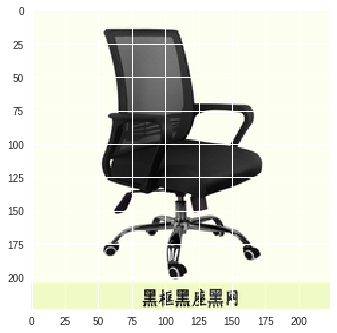

Label: 3

--- Original File ---



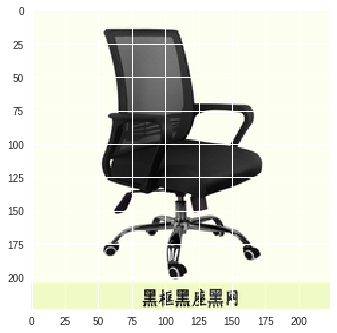

Label: 3


In [0]:
test_ix = np.random.randint(0,(1000*len(build_list) - 1))
print('Testing image',test_ix)

file_num = test_ix // 1000
file_ix = test_ix % 1000

print('\n--- Large File ---\n')
with h5py.File('jumbo.h5', 'r') as hf:
    image = hf['train']['images'][test_ix]
    label= hf['train']['labels'][test_ix]
plt.imshow(image)
plt.show()
print('Label:',label)

print('\n--- Original File ---\n')
with h5py.File(build_list[file_num], 'r') as hf:
    image = hf['train']['images'][file_ix]
    label= hf['train']['labels'][file_ix]
plt.imshow(image)
plt.show()
print('Label:',label)

**Test open and read speeds:**  
Testing on 100 reads.

- **Jumbo file**

In [0]:
test_indices = []
for i in range(100):
    test_indices.append(np.random.randint(0,(1000*len(build_list) - 1)))

In [0]:
open_time = time.time()
ltime = []

with h5py.File('jumbo.h5', 'r') as hf:
    print('File Open Time:', elapsed(open_time))
    for test_ix in test_indices:
        start = time.time()
        image = hf['train']['images'][test_ix]
        label = hf['train']['labels'][test_ix]
        ltime.append(time.time() - start)
print('Total time:', elapsed(open_time))
print("Average read time: {:0.5f}".format(np.mean(ltime)))

File Open Time: 00:02:04.56
Total time: 00:02:05.35
Average read time: 0.00791


**The caching in my favor:**  
Subsequent calls to previously opened connection are lightning fast. Even on completely new images.

![alt text](https://i.pinimg.com/originals/31/91/63/319163316d9295564b0ca58c1d922bcc.gif)

In [0]:
new_indices = []
for i in range(100):
    new_indices.append(np.random.randint(0,(1000*len(build_list) - 1)))

open_time = time.time()
ltime = []

with h5py.File('jumbo.h5', 'r') as hf:
    print('File Open Time:', elapsed(open_time))
    for test_ix in new_indices:
        start = time.time()
        image = hf['train']['images'][test_ix]
        label = hf['train']['labels'][test_ix]
        ltime.append(time.time() - start)
print('Total time:', elapsed(open_time))
print("Average read time: {:0.5f}".format(np.mean(ltime)))

File Open Time: 00:00:00.59
Total time: 00:00:01.03
Average read time: 0.00438


Look at that! 100 openings, instantly.

- **Individual Files**

In [0]:
open_time = time.time()
ltime = []

for test_ix in test_indices:
    file_num = test_ix // 1000
    file_ix = test_ix % 1000

    with h5py.File(build_list[file_num], 'r') as hf:
        start = time.time()
        image = hf['train']['images'][file_ix]
        label= hf['train']['labels'][file_ix]
        ltime.append(time.time() - start)
print('Total time:', elapsed(open_time))
print("Average read time: {:0.5f}".format(np.mean(ltime)))

Total time: 00:04:17.97
Average read time: 0.00619


Slower than the jumbo h5

**And on subsequent calls?**  
Just as slow, even on the exact same images in exact same order.

In [0]:
open_time = time.time()
ltime = []

for test_ix in test_indices:
    file_num = test_ix // 1000
    file_ix = test_ix % 1000

    with h5py.File(build_list[file_num], 'r') as hf:
        start = time.time()
        image = hf['train']['images'][file_ix]
        label= hf['train']['labels'][file_ix]
        ltime.append(time.time() - start)
print('Total time:', elapsed(open_time))
print("Average read time: {:0.5f}".format(np.mean(ltime)))

Total time: 00:03:57.68
Average read time: 0.00619


The answer is clear.. GIANT FILE!

## Compute Additional Data for Training
Only run this the first time, then load from saved .npy's in the future.

I ran `combine_hdf5` on my local machine with images downloaded because Colab kept crashing on me. Apparently GIANT FILE is not the best idea with a cloud instance.

#### Get Training Image $\sigma$

In [0]:
train_sd = np.zeros(shape = (224,224,3), dtype = np.float64)
with h5py.File('../imMaterialist/all_images.h5', 'r') as hf:
    for i in range(189000):
        img_sd = np.square(hf['train']['images'][i], dtype = np.uint64)/189000.
        train_sd += img_sd
        if i % 20000 == 0:
            print(i)

0
20000
40000
60000
80000
100000
120000
140000
160000
180000


Add $\sigma$ to all_images.h5

In [0]:
with h5py.File('../imMaterialist/all_images.h5','r+') as hf:
    hf['train'].create_dataset("std", (224,224,3), np.float32)
    hf["train"]['std'][...] = np.sqrt(train_sd - np.square(train_mean))

** Pointless visualization of $\mu$**... but I can't stop staring at it.

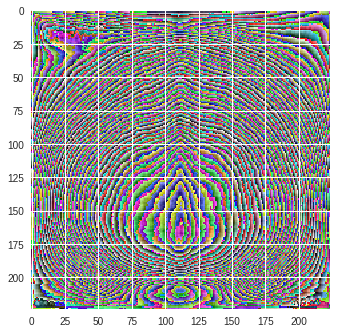

In [0]:
import matplotlib.pyplot as plt
with h5py.File('../imMaterialist/all_images.h5','r') as hf:
    train_mean = hf['train']['mean'][:]
plt.imshow(train_mean)
plt.show()

#### Compute Label Weights

![alt text](https://drive.google.com/uc?id=1vCDfmIV59FK5jC2Ad4-M0fsNwGlnPpnS)

Did this offline while making the giant h5, noticed the label counts are nowhere near even in training data. Whereas in the test data...

![alt text](https://drive.google.com/uc?id=12Y12DAaDFp7V3Bvo-o9T5oZAK06bJ-Ru)

They're pretty uniform. So label weights need to be calculated so that the loss functions can be adjusted during backprogagation.

In [0]:
with h5py.File('../imMaterialist/all_images.h5','r') as hf:
    labels = hf['train']['labels'][:]
label_wts = compute_class_weight('balanced',classes = np.arange(1,129), y = labels)
np.save('label_wts.npy', label_wts)

### Augmentation Tests

Before loading and training the model, quickly verify that augmentation will work as I expect it to in my generator.

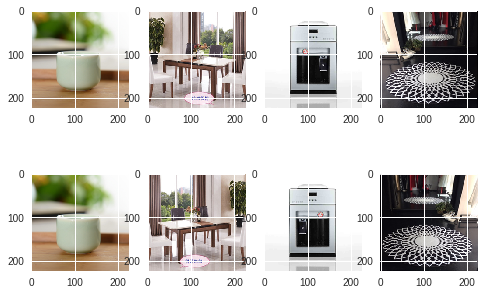

In [0]:
file = load_filelist('../iMaterialist/')[0]
ix = np.random.randint(0,995)
x_train, _ = load_dataset(file, first= ix, last = ix + 5, preprocess=False, raw_labels=True)
datagen = ImageDataGenerator(horizontal_flip = True)

for i in range(4):
    plt.subplot(241 + i)
    plt.imshow(x_train[i])
    plt.subplot(245 + i)
    plt.imshow(datagen.random_transform(x_train[i]))

## Xception Model

On to building the model! I chose Xception for a couple of reasons. Good performance despite being lightweight, which not having a powerful local GPU, I knew would be a major concern for me. The separable convolutions in Xception do a great job of keeping the param count down while still capturing all the same relevant filter information. It also helps that I'm working in Keras and have the suspicion that the package author's own model will be the one most properly implemented (who better to catch a bug early than the guy who built it?!).

### Initial Load
Only did this for first session of transfer loading, after that used `load_model()` to get my latest xception model.

Construction Steps:
- Instantiate xception model with imagenet trained weights loaded.
- Add new top layers.
- Freeze original model layers.
- Train these new top layers until plateau.

In [0]:
xception_model = Xception(weights=None, input_shape = (img_rows, img_cols, img_channels), include_top=False)

In [0]:
x = xception_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(.5)(x)
out = Dense(128, activation='softmax')(x)

model = Model(inputs=xception_model.input, outputs=out)

for layer in xception_model.layers:
    layer.trainable = False

opt = Adam()
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

NameError: ignored

### Load Latest Model
See my drive for file name, last modified 'xception...h5' will be the latest one

In [0]:
model = load_model('weights/xception-unfrozen-apr29-3.h5')
# note, I stopped training xception on Colab awhile ago. Switched to AWS
# P2, now on a P3 for a WRN50.

### Train Model

#### Initial Params, Callbacks, and Other Data

Set weights file name and csv logger file. Weights file is where your best model will be saved. Csv file is where the training record (loss and accuracy for training and validation per epoch) will be saved.

**Note:** I didn't really use the CSVLogger since I was usually assigning my output of fit_generator call to a keras history object which contains the same information (and more) along with its own tidy plotting method. However, it's pretty common for colab to disconnect mid-session and cause me to lose acesss to that history object, so the csv file came in handy for records to see how model improves per epoch, if over/underfitting, etc.

In [0]:
weights_file = 'weights/xception-unfrozen-apr30-2.h5'
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.5), cooldown=0, patience=3, min_lr=2e-7)
csv_logger = CSVLogger('xception-apr30.csv')
model_checkpoint = ModelCheckpoint(weights_file, monitor='val_loss', save_best_only=True,
#                                    save_weights_only=True,
                                   mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=0)

batch_size = 100
nb_classes = 128
n_epochs = 50 

# input image dimensions
img_rows, img_cols = 224, 224
img_channels = 3

Experimented with freezing and unfreezing layers. My initial method after training the output layer was to then unfreeze the last two blocks and continue training the model with that new flexibility.

After results started to plateau, I unfroze all batch normalization layers and surged up almost 10% accuracy in one epoch. This is due to a problem with keras where frozen batch_norm layers [behave differently](https://github.com/keras-team/keras/pull/9965) from unfrozen.

In [0]:
## Unfreezes all batch norm layers.
# bn_type = type(model.layers[2])
# bn_layers = 0
# bn_params = 0
# for i,layer in enumerate(model.layers):
#   if type(layer) == bn_type:
#     layer.trainable = True
#     print(i, layer.name)
#     bn_layers += 1
#     bn_params += layer.count_params()
# print(bn_layers, bn_params)

## Unfreezes last two blocks 
# for layer in model.layers[:115]:
#   layer.trainable = False
# for layer in model.layers[115:]:
#   layer.trainable = True  

In [0]:
# optional, see the layers and if they are trainable.
for i, layer in enumerate(model.layers):
    print(i, layer.name,layer.trainable)

0 input_1 False
1 block1_conv1 False
2 block1_conv1_bn True
3 block1_conv1_act False
4 block1_conv2 False
5 block1_conv2_bn True
6 block1_conv2_act False
7 block2_sepconv1 False
8 block2_sepconv1_bn True
9 block2_sepconv2_act False
10 block2_sepconv2 False
11 block2_sepconv2_bn True
12 conv2d_1 False
13 block2_pool False
14 batch_normalization_1 True
15 add_1 False
16 block3_sepconv1_act False
17 block3_sepconv1 False
18 block3_sepconv1_bn True
19 block3_sepconv2_act False
20 block3_sepconv2 False
21 block3_sepconv2_bn True
22 conv2d_2 False
23 block3_pool False
24 batch_normalization_2 True
25 add_2 False
26 block4_sepconv1_act False
27 block4_sepconv1 False
28 block4_sepconv1_bn True
29 block4_sepconv2_act False
30 block4_sepconv2 False
31 block4_sepconv2_bn True
32 conv2d_3 False
33 block4_pool False
34 batch_normalization_3 True
35 add_3 False
36 block5_sepconv1_act False
37 block5_sepconv1 False
38 block5_sepconv1_bn True
39 block5_sepconv2_act False
40 block5_sepconv2 False
41 bl

In [0]:
# optional, see details on layer name, type, order, shape, input and output
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

Structuring it as I have it, the model was pretty robust to overfitting. But it's started to train slower and plateau. I got it up to almost 82% on AWS and then moved on to a WRN.

My training process was basically
- Unfreeze earlier layers with low learning rates initially, then slowly increase.
- When overfitting, raise the sizes/number of cutout patches being created through the augmentation generator.

---

Once the layers are frozen and unfrozen the to my like I compile the model and resume training.

I used a pretty small learning rate (1e-3) because the images in the contest are fairly similar to Imagenet pretrained weights and I don't want to casually overwrite the extensive pretraining from a massive collection of images the filters already had. I pretty much never unfrozen the bottom blocks for this reason.


In [0]:
opt = Adam(lr= 1e-4)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

Load additional training data:
- $\mu$ and $\sigma$ of training images.
- class weights built from distribution of labels in training images

In [0]:
## These ndarrays are saved in the all_images.h5 file 
## but have also been saved as .npys for faster access.
# with h5py.File('../imMaterialist/all_images.h5') as hf:
#   train_mean = hf['train']['mean'][:]
#   train_std = hf['train']['std'][:]

# np.save('train_mean.npy', train_mean)
# np.save('train_std.npy', train_std)

In [0]:
label_wts = np.load('label_wts.npy')
train_mean = np.load('train_mean.npy')
train_std = np.load('train_std.npy')

#### Create Generators

I create generators for loading training data and validation data, only using the augmentation engine on the training data.

In [0]:
batch_size = 60
# Generators
image_aug_gen = ImageDataGenerator(horizontal_flip=True,
                                   rotation_range=45,
                                   width_shift_range=0.3,
                                   height_shift_range=0.3,
                                   shear_range=0.1,
                                   zoom_range=0.2,
                                   fill_mode='constant',
                                   cval = 0,
                                   preprocessing_function = cutout)

training_generator = FullDataGenerator('../imMaterialist/all_images.h5',batch_size = batch_size,
                                       train_mean = train_mean, train_std = train_std,
                                       augment_generator=image_aug_gen,
                                       shuffle = 'semi')
validation_generator = FullDataGenerator('../imMaterialist/all_images.h5', key = 'test',
                                         train_mean = train_mean, train_std = train_std,
                                         batch_size = batch_size, file_size=6000)

#### Fit Model

This takes a _**long**_ time to load (~2-5mins) regardless of batch size / steps per epoch / epochs. This is because the generators being used read from one massive h5 file. This means some time is required to form the initil file connection, but once open data is read very quickly.

In [0]:
n_epochs = 50

# Train model on dataset
history = model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=True,
                    workers=6,
                    epochs=n_epochs,
                    verbose=1,
                    steps_per_epoch = 500,
                    validation_steps = 100,
                    class_weight = label_wts,
                    shuffle = False,
                    callbacks=[lr_reducer, model_checkpoint])

Epoch 1/50
500/500 [==============================] - 1211s 2s/step - loss: 0.8290 - acc: 0.7558 - val_loss: 0.8912 - val_acc: 0.7542


I repeated this training, layer freeze/unfreeze, cutout modifying, and learning rate adjustment until I had exception as far trained as I could get it. But this is just the setup. The real point of all this it get the model ready for TTA!